# Q1


In [1]:
import numpy as np
import math
np.set_printoptions(suppress=True)

from scipy.integrate import quad, dblquad


def cal_K(i, j, N):
    if i == j:
        return math.factorial(N) / (math.factorial(i - 1) * math.factorial(N - i))
    return math.factorial(N) / (math.factorial(i - 1) * math.factorial(j - i - 1) * math.factorial(N - j))


def integrand(i, j, N):
    if i == j:
        return quad(lambda x: (x ** 2) * (1 + x) ** (i - 1) * (1 - x) ** (N - i) * (0.5) ** N * cal_K(i, j, N), -1, 1)[0]
    
    def inner_integrand(y1, y2):
        return y1 * y2 * (((y1 + 1) / 2) ** (i - 1)) * (((y2 - y1) / 2) ** (j - i - 1)) * (((1 - (y2 + 1) / 2)) ** (N - j)) * 0.25 * cal_K(i, j, N)
    
    return dblquad(inner_integrand, -1, 1, -1, lambda y2: y2)[0]


def calculate_H_matrix(n):
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            H[i][j] = integrand(i + 1, j + 1, N=n)
            H[j][i] = H[i][j]
    return H


def calculate_alpha(H):
    e = np.ones((H.shape[0], 1))
    alpha = np.linalg.inv(H) @ e / (np.transpose(e) @ np.linalg.inv(H) @ e)
    return alpha


if __name__ == "__main__":
    n = 5
    H = calculate_H_matrix(n)
    print("H matrix:\n", H)

    alpha = calculate_alpha(H)
    print("\nOptimal coefficient matrix:\n", alpha)


H matrix:
 [[ 0.52380952  0.28571429  0.04761905 -0.19047619 -0.42857143]
 [ 0.28571429  0.23809524  0.0952381  -0.04761905 -0.19047619]
 [ 0.04761905  0.0952381   0.14285714  0.0952381   0.04761905]
 [-0.19047619 -0.04761905  0.0952381   0.23809524  0.28571429]
 [-0.42857143 -0.19047619  0.04761905  0.28571429  0.52380952]]

Optimal coefficient matrix:
 [[ 0.5]
 [-0. ]
 [-0. ]
 [-0. ]
 [ 0.5]]


# Q2


In [8]:
!pip install bm3d
!pip install --upgrade bm3d


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import img_as_float
import pywt
import bm3d
from skimage import measure

# Load the lighthouse image
img = io.imread("lighthouse2.bmp")

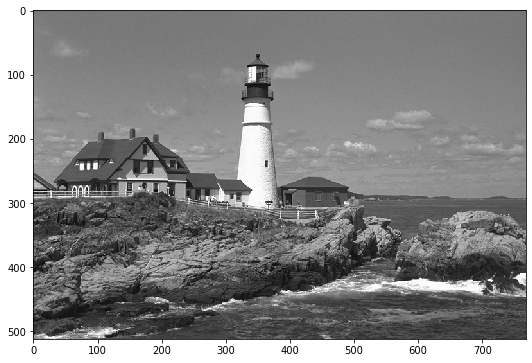

In [10]:
# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
io.imshow(gray_img)


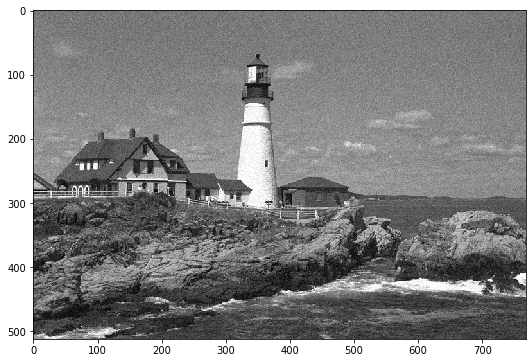

In [11]:
# Add white Gaussian noise with variance 100
noise = np.random.normal(scale=10, size=gray_img.shape)
noisy_img = gray_img + noise
noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
io.imshow(noisy_img)


Denoised Image output of 1st stage


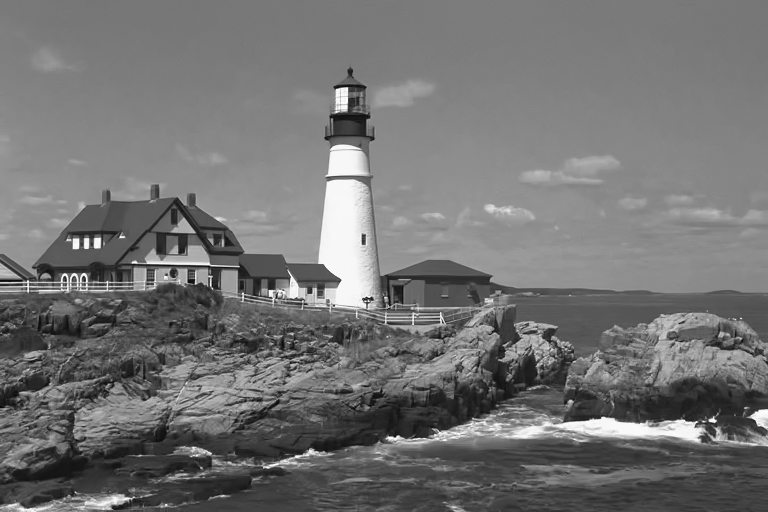

Denoised Image output of 2nd Stage


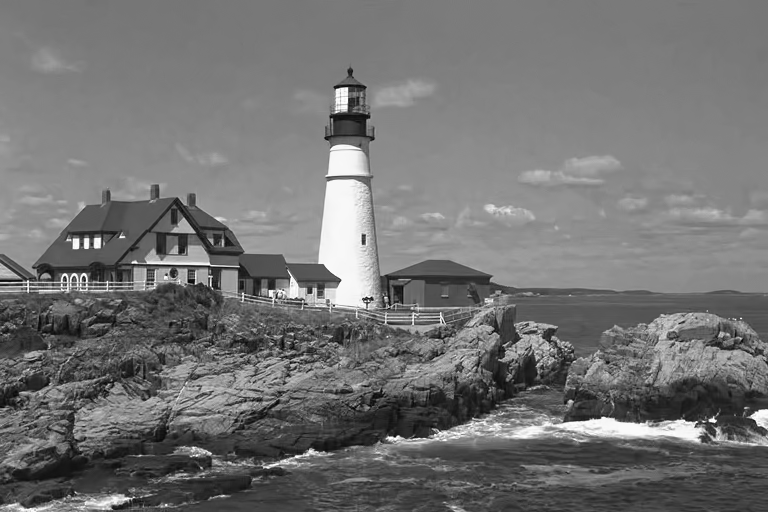

In [23]:
# Denoise the image using BM3D
denoised_img_1 = bm3d.bm3d(noisy_img, sigma_psd=10, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
denoised_img_2 = bm3d.bm3d(noisy_img, sigma_psd=10, stage_arg=bm3d.BM3DStages.ALL_STAGES)

print("Denoised Image output of 1st stage\n\n")
cv2_imshow(denoised_img_1)

print("\n\nDenoised Image output of 2nd Stage\n\n")
cv2_imshow(denoised_img_2)

In [13]:
# Calculate the MSE between the denoised images and the original image
mse_1 = np.mean((denoised_img_1 - gray_img)**2)
mse_2 = np.mean((denoised_img_2 - gray_img)**2)

print("MSE at the output of the first stage: ", mse_1)
print("MSE at the output of all stages: ", mse_2)


MSE at the output of the first stage:  33.14347956173951
MSE at the output of all stages:  28.124488887013072


# Q2b

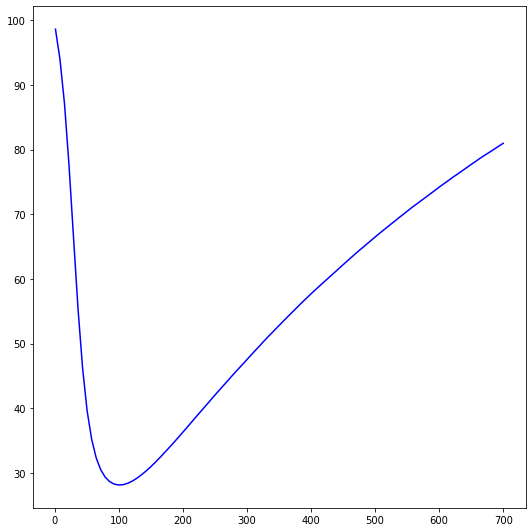

In [14]:
noise_variance = np.linspace(1,700,100)

mse_array = []

plt.rcParams["figure.figsize"] = [7.50, 7.50]
plt.rcParams["figure.autolayout"] = True

for sigma in noise_variance:
  denoised_img = bm3d.bm3d(noisy_img, sigma_psd=sigma**0.5, stage_arg=bm3d.BM3DStages.ALL_STAGES)
  mse = np.mean((denoised_img - gray_img)**2)
  mse_array.append(mse) 

plt.plot(noise_variance, mse_array, color = 'blue')
plt.show()

# Q2c

Mean Square Variance when Weiner Filter is replaced with Hard Thresholding is: 63.6447656142856


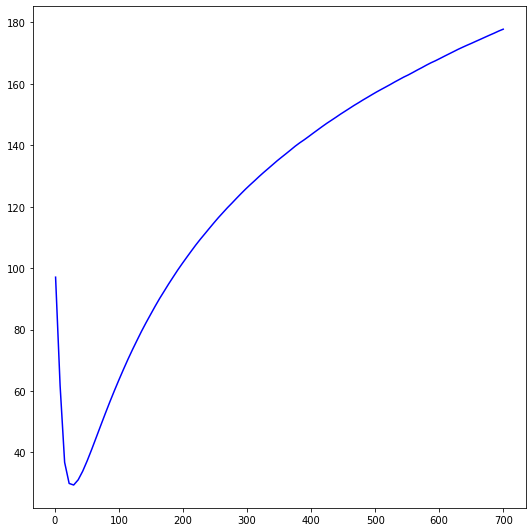

In [24]:
first_stage_output = bm3d.bm3d(noisy_img, sigma_psd=10, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
final_denoised_img = bm3d.bm3d(first_stage_output, sigma_psd=10, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
mse_f = np.mean((final_denoised_img - gray_img)**2)
print("Mean Square Variance when Weiner Filter is replaced with Hard Thresholding is:", mse_f )

noise_variance_1 = np.linspace(1,700,100)

mse_array_1 = []

plt.rcParams["figure.figsize"] = [7.50, 7.50]
plt.rcParams["figure.autolayout"] = True

for sigma_1 in noise_variance_1:
  first_stage_output = bm3d.bm3d(noisy_img, sigma_psd=sigma_1**0.5, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
  final_denoised_img = bm3d.bm3d(first_stage_output, sigma_psd=sigma_1**0.5, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
  mse_c = np.mean((final_denoised_img - gray_img)**2)
  mse_array_1.append(mse_c) 



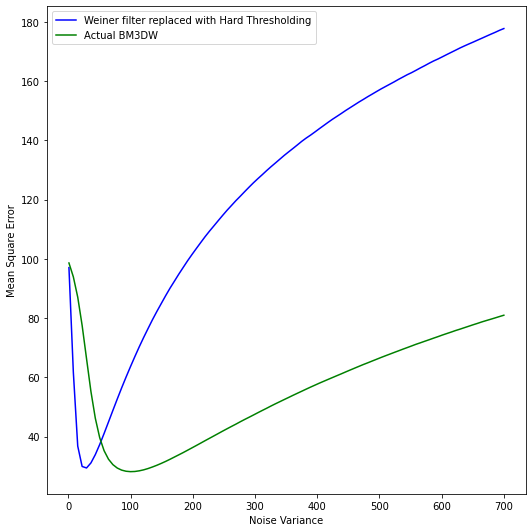

In [27]:
plt.plot(noise_variance_1, mse_array_1, color = 'blue', label = 'Weiner filter replaced with Hard Thresholding')
plt.plot(noise_variance, mse_array, color = 'green', label = 'Actual BM3DW'  )

plt.xlabel("Noise Variance")
plt.ylabel("Mean Square Error")

plt.legend()

plt.show()